In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim
import pandas as pd
import matplotlib.pyplot as plt
import anndata
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ensure root directory of the project
import os
if not os.getcwd().endswith('perturbations'):
    os.chdir('/home/fvk220/fvk220/sc-perturbations')

# load custom classes and functions
from _models import NBVAE
import _utils
from _utils import set_all_seeds, truncate_colormap, set_plt_layout, take_cmap_colors
from _utils import load_model, save_model, evaluate_dataset
from _training import train_nbvae_ctx
set_all_seeds(0)
set_plt_layout()


class RNA(Dataset):
    def __init__(self, data_file, subset=None):
        # load the scRNA-seq data from the specified file
        self.data = anndata.read_h5ad(data_file)
        self.data = self.data[subset] if subset is not None else self.data
        self.genes = self.data.var_names.values
        self.cells = self.data.obs_names.values
        self.obs = self.data.obs
        self.data = torch.from_numpy(self.data.X.toarray())
        print(self.data.shape)

        self.compound = torch.tensor(self.obs["compound_int"].astype(float), dtype=torch.float32)
        self.compound_unmasked = self.compound.clone()

        # scale cell counts by their mean
        self.data_mean = torch.mean(self.data, dim=-1, keepdim=True)
        self.normalized_data = self.data / self.data_mean
        self.log_data = torch.log1p(self.normalized_data)

        print("Before norm:", torch.min(self.data), torch.max(self.data))
        print("After norm:", torch.min(self.normalized_data), torch.max(self.normalized_data))
        print("Log data:", torch.min(self.log_data), torch.max(self.log_data))

    def __len__(self):
        # return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, index):
        # return the preprocessed data for the specified example
        return index, self.data[index], self.data_mean[index], self.normalized_data[index], self.log_data[index], self.compound[index]


dev = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
bs = 2**12 # 2**11
train_pct = 0.82; val_pct = 0.09; test_pct = 0.09

# Load the dataset only once
full_dataset = RNA("data/cardiotoxin/anndata_hvg.h5ad")

# Split into train, validation, and test subsets
indices = np.arange(len(full_dataset))
np.random.shuffle(indices)

train_end = int(len(full_dataset) * train_pct)
val_end = int(len(full_dataset) * train_pct + len(full_dataset) * val_pct)

train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]

# Define a function to generate subset data loader
def get_subset_loader(indices):
    subset = torch.utils.data.Subset(full_dataset, indices)
    return DataLoader(subset, batch_size=bs, shuffle=True)

train_loader = get_subset_loader(train_indices)
val_loader = get_subset_loader(val_indices)
test_loader = get_subset_loader(test_indices)

# SAMPLING RANDOM CELLS TO BE UNLABELLED
label_proportion = 0.1
sampled_indices = np.random.choice(train_indices, int(label_proportion * len(train_indices)), replace=False)
for idx in sampled_indices:
    full_dataset.compound[idx] = -1

print("Proportion of labelled cells:", label_proportion)
print("Sizes:", len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

2025-02-24 19:10:45.687401: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 19:10:45.708798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 19:10:45.733848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 19:10:45.741589: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 19:10:45.766336: I tensorflow/core/platform/cpu_feature_guar

torch.Size([53230, 1950])
Before norm: tensor(0.) tensor(2265.)
After norm: tensor(0.) tensor(685.0846)
Log data: tensor(0.) tensor(6.5310)
Proportion of labelled cells: 0.1
Sizes: 43648 4791 4791


In [3]:
# TRAIN SINGLE MODEL
model_params = {"input_dim": len(full_dataset.data[0]), "latent_dim": 2, "scaling_type": "mean", "extra_outputs": 1}
vae = NBVAE(**model_params).to(dev)
vae_opt = optim.Adam(vae.parameters(), lr=1.2e-3, weight_decay=1e-5, amsgrad=True)
vae, vae_loss_hist = train_nbvae_ctx(vae, vae_opt, train_loader, val_loader, 1000, beta=10, ce_weight=1000, warmup_epochs=10, patience=10, dev=dev)


Epochs:   6%| | 57/1000 [01:34<25:59,  1.65s/it, Loss=1345.8242, Recon=1315.4796, KL=2.9236, CE=0.0011, Val=1411.4404

Early stopping
Best epoch: 47 val loss: 1406.8397124817366


In [4]:
# save_model(vae, vae_opt, vae_loss_hist, model_params, 'ctx')

# p = "checkpoints/ctx_20250221_170330.pt"
# vae, _, _, model_params = load_model(p, model_type='nbvae', dev=dev)

best k: 3 ari: 0.7686570331897759
ari: 0.7687
rmse: 0.2743 mae: 0.3165 Sub acc: 0.9958 All acc: 0.9954 Sub F1: 0.9968 All F1: 0.9965
gene indices: [-1]


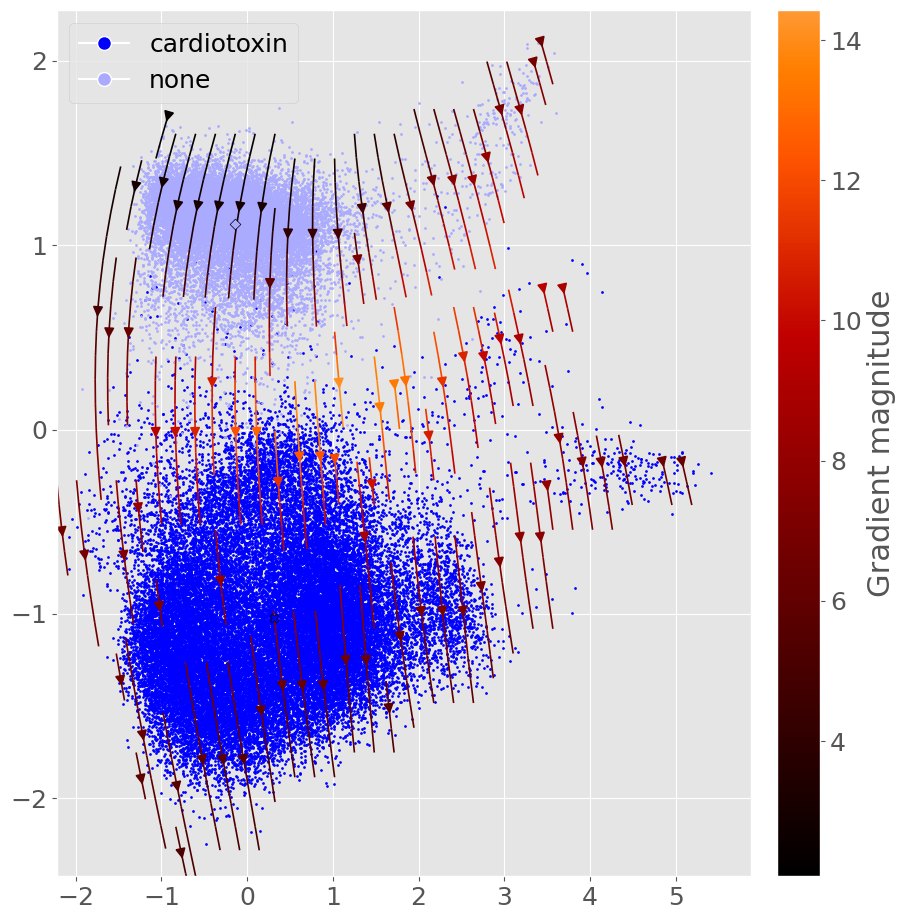

In [5]:
from scipy.ndimage import binary_dilation

# use full dataset 
x_hat, mu, metrics = evaluate_dataset(full_dataset.data, full_dataset.log_data, full_dataset.data_mean,
      vae, "cardiotoxin", compute_ari=True, ari_ks=np.arange(2,4,1), labels=full_dataset.compound_unmasked,
      mask=full_dataset.compound!=-1, obs=full_dataset.obs
)
metrics = pd.DataFrame([metrics])

boundaries = 1.15 * np.quantile(mu, [0.0001, 0.9999], axis=0)
x_min, y_min = boundaries[0]
x_max, y_max = boundaries[1]
rectangle = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max], [x_min, y_min]])

# create a grid in the boundary region
grid_size = 35
x_grid = np.linspace(x_min, x_max, grid_size)
y_grid = np.linspace(y_min, y_max, grid_size)
x1, x2 = np.meshgrid(x_grid, y_grid)

# flatten grid to list of (x1, x2) pairs
flat = np.vstack([x1.flatten(), x2.flatten()]).T

gene_idx = [-1]
print("gene indices:", gene_idx)

# compute gradients and unflatten
J = vae.grad_wrt_i(torch.tensor(flat).to(dev).float(), gene_idx).detach().cpu().numpy()
# J = J / np.linalg.norm(J, axis=2).reshape(-1,len(gene_idx),1) # unit norm
J = J.mean(axis=1)
# J[np.linalg.norm(J, axis=1) < 0.1] = 0 # hide small gradients

xx = J[:,0].reshape(len(x_grid), len(x_grid))
yy = J[:,1].reshape(len(y_grid), len(y_grid))
magnitude = np.sqrt(xx**2 + yy**2)

# mask out the region outside points
hist, _, _ = np.histogram2d(mu[:, 0].numpy(), mu[:, 1].numpy(), bins=[x_grid, y_grid])
mask = hist.T > 0
mask_padded = np.pad(mask, ((0, 1), (0, 1)), mode='constant')
mask_dilated = binary_dilation(mask_padded, iterations=1)
xx = np.where(mask_dilated, xx, np.nan)
yy = np.where(mask_dilated, yy, np.nan)

# labels
obs = full_dataset.obs.copy()
c = obs.compound

# mean of each cell type
obs[["x", "y"]] = mu
cell_type_means = obs.groupby(["compound"])[["x","y"]].mean()

# colors
cmap_colors = take_cmap_colors(truncate_colormap("bwr", 0, 1), 4)
adjusted_cmap_colors = [cmap_colors[0], cmap_colors[1], cmap_colors[2], cmap_colors[3]]
cell_types = c.value_counts().index.astype("str").values
cell_type_to_color = {cell_type: color for cell_type, color in zip(cell_types, adjusted_cmap_colors)}

# plotting -----------
fig, ax = plt.subplots(1,1, figsize=(9,9))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# scatter
for cell_type in cell_types:
    mask = full_dataset.obs['compound'].values == cell_type
    plt.scatter(mu[mask,0], mu[mask,1], c=[cell_type_to_color[cell_type]], s=2, label=cell_type)
scatters = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) for c in cell_type_to_color.values()]
plt.legend(scatters, cell_types, loc="upper left")

# streamplot
stream = plt.streamplot(x1, x2, xx, yy, linewidth=1.2, color=magnitude, cmap=truncate_colormap("gist_heat", 0, 0.8),
     density=(1.2, 1.2), minlength=0.03, maxlength=0.4, arrowstyle='-|>', arrowsize=1.5)
cbar = fig.colorbar(stream.lines, ax=ax, pad=0.03, shrink=1, aspect=20, label="Gradient magnitude")

# cell type means
wildtypes = cell_type_means.loc['none'].dropna()
experiments = cell_type_means.loc['cardiotoxin'].dropna()
plt.scatter(wildtypes["x"], wildtypes["y"], s=30, color=cell_type_to_color[wildtypes.name], marker="D", edgecolors="black", zorder=np.inf)
plt.scatter(experiments["x"], experiments["y"], s=40, color=cell_type_to_color[experiments.name], marker="X", edgecolors="black", zorder=np.inf)
plt.tight_layout(pad=0)

# plt.savefig(f"data/ctx_hidpi_final2.png", dpi=300, bbox_inches='tight')
plt.show()


In [6]:
# TRAIN N_ITER MODELS
compute_ari = True
n_iter = 5
model_params = {"input_dim": len(full_dataset.data[0]), "latent_dim": 2, "scaling_type": "mean", "extra_outputs": 1}

train_results = []
test_results = []
for i in range(n_iter):
    # init model and train
    vae = NBVAE(**model_params).to(dev)
    vae_opt = optim.Adam(vae.parameters(), lr=1.2e-3, weight_decay=1e-5, amsgrad=True)
    vae, vae_loss_hist = train_nbvae_ctx(vae, vae_opt, train_loader, val_loader, 1000, beta=10, ce_weight=1000, warmup_epochs=10, patience=10, dev=dev)
    vae.eval()

    print("TRAIN METRICS--------")
    _, _, train_metrics = evaluate_dataset(full_dataset.data[train_indices], full_dataset.log_data[train_indices],
                                           full_dataset.data_mean[train_indices], vae, "cardiotoxin", compute_ari, np.arange(1,5,1),
                                           full_dataset.compound_unmasked[train_indices], full_dataset.compound[train_indices]!=1, full_dataset.obs.iloc[train_indices])
    print("\nTEST METRICS-------")
    _, _, test_metrics  = evaluate_dataset(full_dataset.data[test_indices], full_dataset.log_data[test_indices],
                                           full_dataset.data_mean[test_indices], vae, "cardiotoxin", compute_ari, np.arange(1,5,1),
                                           full_dataset.compound_unmasked[test_indices], full_dataset.compound[test_indices]!=1, full_dataset.obs.iloc[test_indices])

    # append to lists with extra n_iter column
    train_results.append({'n_iter': i, **train_metrics})
    test_results.append({'n_iter': i, **test_metrics})

# convert to dataframe
train_df = pd.DataFrame(train_results)
test_df = pd.DataFrame(test_results)

# write dataframes with tamestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
train_df.to_csv(f"data/ctx_train_{timestamp}.csv")
test_df.to_csv(f"data/ctx_test_{timestamp}.csv")

# Calculate mean and standard deviation for train metrics
train_mean = train_df.drop(columns=["n_iter"]).mean()
train_std = train_df.drop(columns=["n_iter"]).std()
test_mean = test_df.drop(columns=["n_iter"]).mean()
test_std = test_df.drop(columns=["n_iter"]).std()

# Print the results
print("\nTRAIN STATISTICS--------")
for metric in train_mean.index:
    print(f"{metric} - Mean: ${train_mean[metric]:.4f} \pm {train_std[metric]:.4f}$")

print("\nTEST STATISTICS--------")
for metric in test_mean.index:
    print(f"{metric} - Mean: ${test_mean[metric]:.4f} \pm {test_std[metric]:.4f}$")


Epochs:   0%|                                                                               | 0/1000 [00:00<?, ?it/s]

Epochs:   5%| | 50/1000 [01:17<24:40,  1.56s/it, Loss=1344.4685, Recon=1313.5524, KL=3.0350, CE=0.0006, Val=1424.0572

Early stopping
Best epoch: 40 val loss: 1418.729336255479
TRAIN METRICS--------


best k: 3 ari: 0.7933337236788787
ari: 0.7933
rmse: 0.2685 mae: 0.3124 Sub acc: 0.9975 All acc: 0.9990 Sub F1: 0.9927 All F1: 0.9992

TEST METRICS-------
best k: 3 ari: 0.7737484767083114
ari: 0.7737
rmse: 0.2681 mae: 0.3124 Sub acc: 0.9876 All acc: 0.9904 Sub F1: 0.0000 All F1: 0.9928


Epochs:   7%| | 68/1000 [01:46<24:23,  1.57s/it, Loss=1334.3538, Recon=1305.6508, KL=2.8329, CE=0.0004, Val=1409.5312

Early stopping
Best epoch: 58 val loss: 1407.6757461907744
TRAIN METRICS--------


best k: 3 ari: 0.6831543271018783
ari: 0.6832
rmse: 0.2685 mae: 0.3125 Sub acc: 0.9975 All acc: 0.9990 Sub F1: 0.9927 All F1: 0.9993

TEST METRICS-------
best k: 3 ari: 0.6841953650269236
ari: 0.6842
rmse: 0.2682 mae: 0.3124 Sub acc: 0.9895 All acc: 0.9917 Sub F1: 0.0000 All F1: 0.9937


Epochs:   4%| | 42/1000 [01:08<25:59,  1.63s/it, Loss=1350.8330, Recon=1320.0626, KL=3.0191, CE=0.0006, Val=1432.3965

Early stopping
Best epoch: 32 val loss: 1422.0671049885202
TRAIN METRICS--------


best k: 3 ari: 0.764436386403793
ari: 0.7644
rmse: 0.2698 mae: 0.3126 Sub acc: 0.9979 All acc: 0.9992 Sub F1: 0.9939 All F1: 0.9994

TEST METRICS-------
best k: 3 ari: 0.7495903118396129
ari: 0.7496
rmse: 0.2696 mae: 0.3127 Sub acc: 0.9895 All acc: 0.9914 Sub F1: 0.0000 All F1: 0.9935


Epochs:   5%| | 49/1000 [01:18<25:15,  1.59s/it, Loss=1344.7777, Recon=1314.0778, KL=3.0103, CE=0.0006, Val=1406.4246

Early stopping
Best epoch: 39 val loss: 1399.7276012314758
TRAIN METRICS--------


best k: 3 ari: 0.7998201515341375
ari: 0.7998
rmse: 0.2668 mae: 0.3111 Sub acc: 0.9979 All acc: 0.9992 Sub F1: 0.9939 All F1: 0.9994

TEST METRICS-------
best k: 3 ari: 0.7901596730461807
ari: 0.7902
rmse: 0.2664 mae: 0.3110 Sub acc: 0.9889 All acc: 0.9912 Sub F1: 0.0000 All F1: 0.9934


Epochs:   4%| | 44/1000 [01:11<26:02,  1.63s/it, Loss=1347.0701, Recon=1314.9632, KL=3.1441, CE=0.0007, Val=1448.8917

Early stopping
Best epoch: 34 val loss: 1437.2006757461909
TRAIN METRICS--------


best k: 3 ari: 0.8221165546538324
ari: 0.8221
rmse: 0.2647 mae: 0.3093 Sub acc: 0.9977 All acc: 0.9990 Sub F1: 0.9932 All F1: 0.9993

TEST METRICS-------
best k: 3 ari: 0.8019273948811709
ari: 0.8019
rmse: 0.2641 mae: 0.3091 Sub acc: 0.9932 All acc: 0.9917 Sub F1: 0.0000 All F1: 0.9937

TRAIN STATISTICS--------
acc - Mean: $0.9977 \pm 0.0002$
acc_all - Mean: $0.9991 \pm 0.0001$
f1 - Mean: $0.9933 \pm 0.0006$
f1_all - Mean: $0.9993 \pm 0.0001$
rmse - Mean: $0.2677 \pm 0.0020$
mae - Mean: $0.3116 \pm 0.0014$
ari - Mean: $0.7726 \pm 0.0541$

TEST STATISTICS--------
acc - Mean: $0.9897 \pm 0.0021$
acc_all - Mean: $0.9913 \pm 0.0005$
f1 - Mean: $0.0000 \pm 0.0000$
f1_all - Mean: $0.9934 \pm 0.0004$
rmse - Mean: $0.2673 \pm 0.0021$
mae - Mean: $0.3115 \pm 0.0015$
ari - Mean: $0.7599 \pm 0.0467$
